In [ ]:
!pip install fuzzy-c-means

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.15.1
    Uninstalling typer-0.15.1:
      Successfully uninstalled typer-0.15.1
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.31.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
from fcmeans import FCM
from matplotlib import pyplot as plt

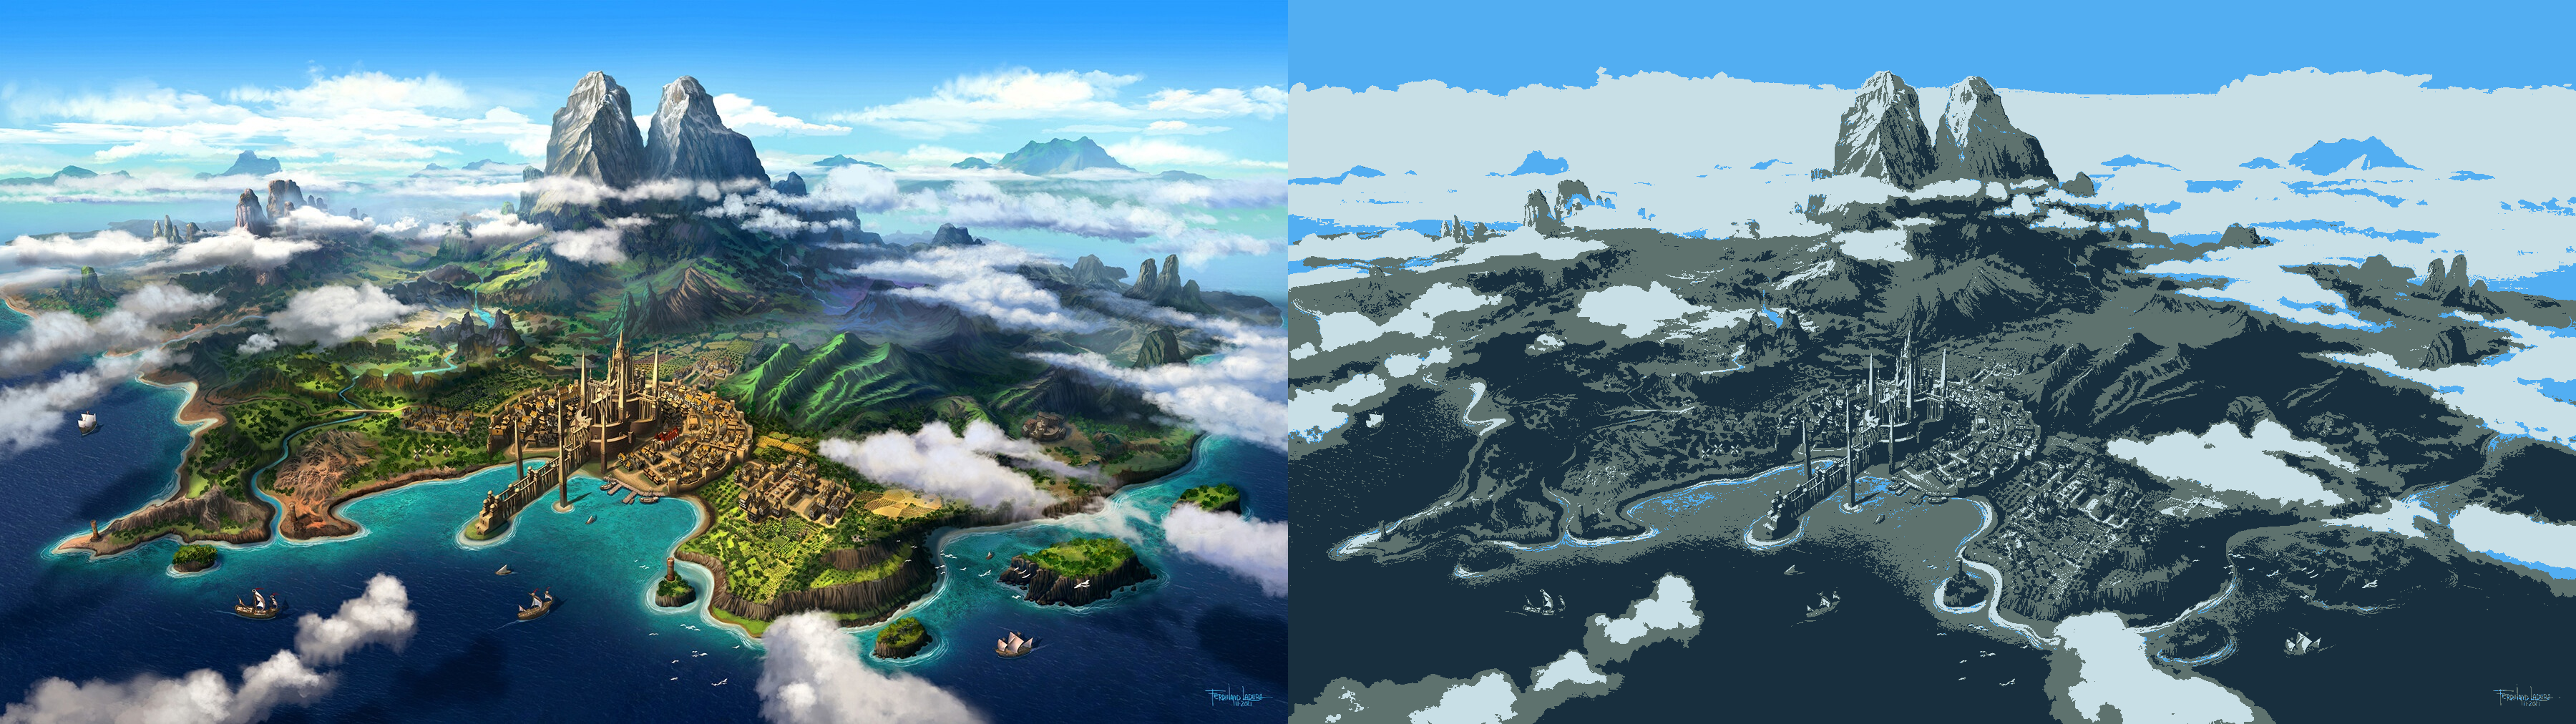

In [ ]:
from fcmeans import FCM
img = Image.open('image.jpg')
N, M = img.size
X = np.asarray(img).reshape(N*M, 3)
fcm = FCM(n_clusters=4)
fcm.fit(X)

labeld_X = fcm.predict(X)
transformed_X = fcm.centers[labeld_X]
quatized_array = transformed_X.astype('uint8').reshape((M, N, 3))

quatized_image = Image.fromarray(np.asarray(quatized_array))

side_by_side = Image.fromarray(np.hstack([np.array(img), np.array(quatized_image)]))
side_by_side

In [ ]:
from sklearn.metrics.pairwise import manhattan_distances
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def FCM(X, c=2, m=2, epsi=0.001, metric='euclidean'):

    n = X.shape[0]
    f = X.shape[1]

    U0 = np.random.rand(n, c)
    U0 = U0 / U0.sum(axis=1)[:, None]
    U_current, U_prev = U0, U0

    k = 0

    while (True):

        C = (((U_prev ** m).T[:, :, None]) * X).sum(axis=1)
        C = C / (((U_prev ** m).T).sum(axis=1)[:, None])

        if metric == 'euclidean':
            distance = (((X[:, None, :] - C[None, :, :]) ** 2).sum(axis=2)) ** 0.5
        elif metric == 'manhattan':
            distance = np.abs(X[:, None, :] - C[None, :, :]).sum(axis=2)
        elif metric == 'chebyshev':
            distance = np.abs(X[:, None, :] - C[None, :, :]).max(axis=2)
        elif metric == 'cosine':
            distance = 1 - cosine_similarity(X, C)

        U_current = distance[:, :, None] * ((1 / distance)[:, None, :])
        U_current = (U_current ** (2 / (m - 1))).sum(axis=2)
        U_current = 1 / U_current

        if (np.abs(U_current - U_prev)).max(axis=(0, 1)) < epsi:
            break
        U_prev = U_current
        k += 1

    return U_current, C


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import numpy as np

def segment_image(im,labels,center,verbose):
    n = len(np.unique(labels))
    f_img = np.zeros_like(im,dtype=np.int64)
    segs = list(np.unique(labels))
    for i in range(n):
        if verbose:
            print(i)
        mask_indx = np.where((labels==segs[i]))
        mask = np.zeros_like(im[:,:,0],dtype=np.int64)
        mask[mask_indx] = 1
        f_img[:,:,0] += mask * int(center[segs[i],0] * 256)
        f_img[:,:,1] += mask * int(center[segs[i],1] * 256)
        f_img[:,:,2] += mask * int(center[segs[i],2] * 256)
    return f_img

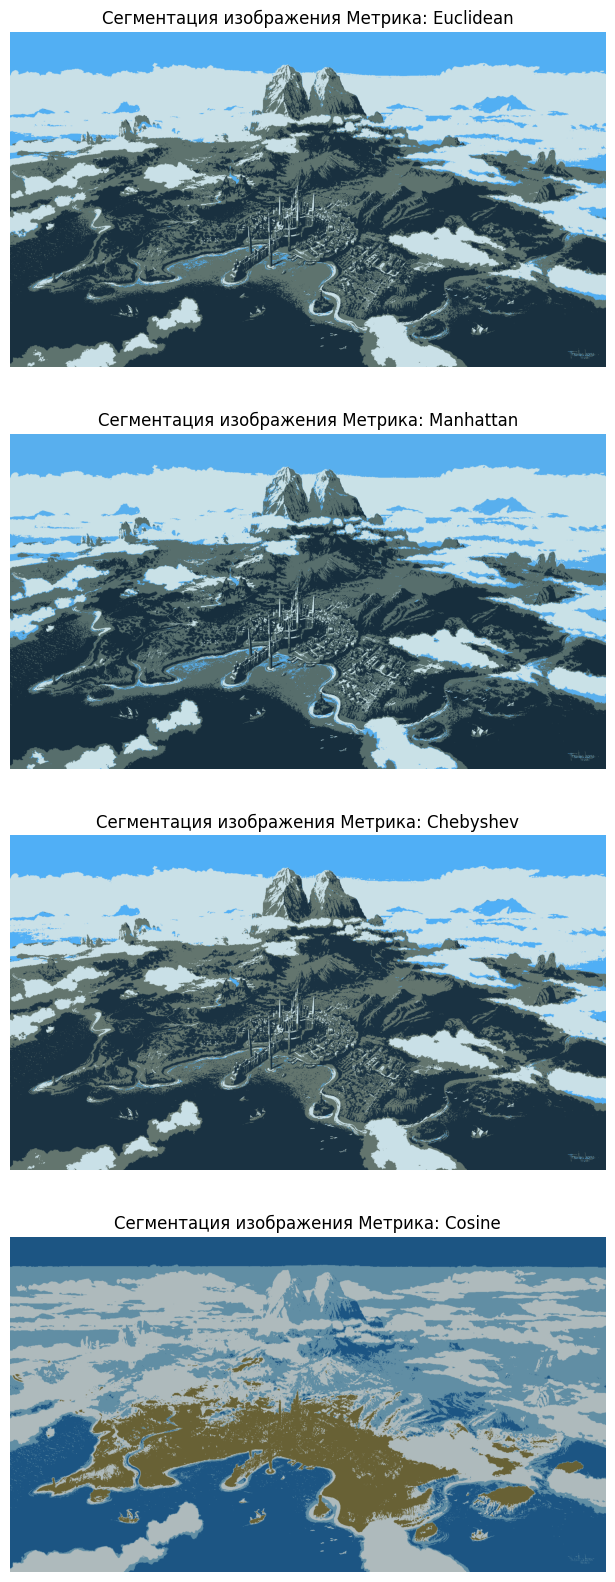

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import img_as_float

def sample_fcm_image():
    metrics = ['euclidean', 'manhattan', 'chebyshev', 'cosine']
    _, axes = plt.subplots(len(metrics), 1, figsize=(20, 20))

    img = cv2.imread('image.jpg')
    img = img_as_float(img)
    x = np.reshape(img, (img.shape[0] * img.shape[1], 3), order='F')

    for i, metric in enumerate(metrics):
        verbose = 0
        m, c = FCM(x, c=4, metric=metric)
        labels = m.argmax(axis=1)
        m = np.reshape(labels, (img.shape[0], img.shape[1]), order='F').astype('uint8')
        segmented_img = segment_image(img, m, c, verbose)

        axes[i].set_axis_off()
        axes[i].imshow(segmented_img[:, :, ::-1])
        axes[i].set_title("Сегментация изображения Метрика: " + metric.capitalize())

    plt.show()

sample_fcm_image()



In [ ]:
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import time
import matplotlib.pyplot as plt
import tracemalloc

# Собственная реализация алгоритма FCM
def FCM(X, c=2, m=2, epsi=0.001, metric='euclidean'):
    n = X.shape[0]
    f = X.shape[1]

    U0 = np.random.rand(n, c)
    U0 = U0 / U0.sum(axis=1)[:, None]
    U_current, U_prev = U0, U0

    while True:
        # Вычисление центроидов
        C = (((U_prev ** m).T[:, :, None]) * X).sum(axis=1)
        C = C / (((U_prev ** m).T).sum(axis=1)[:, None])

        # Вычисление расстояний
        if metric == 'euclidean':
            distance = (((X[:, None, :] - C[None, :, :]) ** 2).sum(axis=2)) ** 0.5
        elif metric == 'manhattan':
            distance = np.abs(X[:, None, :] - C[None, :, :]).sum(axis=2)
        elif metric == 'chebyshev':
            distance = np.abs(X[:, None, :] - C[None, :, :]).max(axis=2)
        elif metric == 'cosine':
            distance = 1 - cosine_similarity(X, C)

        U_current = distance[:, :, None] * ((1 / distance)[:, None, :])
        U_current = (U_current ** (2 / (m - 1))).sum(axis=2)
        U_current = 1 / U_current

        # Проверка сходимости
        if (np.abs(U_current - U_prev)).max(axis=(0, 1)) < epsi:
            break
        U_prev = U_current

    return U_current, C

# Загрузка изображения и преобразование
img = Image.open('image3.jpg')
N, M = img.size
X = np.asarray(img).reshape(N * M, 3)

# Тест: Использование памяти и время выполнения для FCM
tracemalloc.start()
start_time = time.time()
custom_U, custom_centroids = FCM(X, c=4)
custom_labels = np.argmax(custom_U, axis=1)
custom_segmented = custom_centroids[custom_labels].astype('uint8').reshape((M, N, 3))
custom_time = time.time() - start_time
custom_memory = tracemalloc.get_traced_memory()[1]
tracemalloc.stop()

# Вычисление средней дистанции до центроида для FCM
custom_inertia = np.mean(
    np.min(((X[:, None, :] - custom_centroids[None, :, :]) ** 2).sum(axis=2), axis=1)
)

# Тест: Использование памяти и время выполнения для K-means
tracemalloc.start()
start_time = time.time()
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)
kmeans_labels = kmeans.labels_
kmeans_segmented = kmeans.cluster_centers_[kmeans_labels].astype('uint8').reshape((M, N, 3))
kmeans_time = time.time() - start_time
kmeans_memory = tracemalloc.get_traced_memory()[1]
tracemalloc.stop()

# Инерция для K-means
kmeans_inertia = kmeans.inertia_

# Вывод результатов
print(f"Собственная реализация: время = {custom_time:.2f} сек, память = {custom_memory / 1e6:.2f} МБ, инерция = {custom_inertia:.2f}")
print(f"Библиотечная реализация: время = {kmeans_time:.2f} сек, память = {kmeans_memory / 1e6:.2f} МБ, инерция = {kmeans_inertia:.2f}")

# Визуализация через matplotlib
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Оригинальное изображение")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Сегментация (Собственная реализация)")
plt.imshow(custom_segmented)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Сегментация (K-means Sklearn)")
plt.imshow(kmeans_segmented)
plt.axis("off")

plt.show()



KeyboardInterrupt: 